## Module Title:	 Data Visualization Techniques  & Machine Learning for Business 
### Assessment Title: Integrated CA
### Lecturer Name:	 David McQuaid  & PhD Muhammad Iqbal
### Student Full Name & Student ID:	Natalia de Oliveira Rodrigues 2023112

### GitHub Repository: 
https://github.com/norodrigues111/Recommendation-System-and-Market-Basket-Analysis.git

### Dataset Source:
https://www.kaggle.com/datasets/rashikrahmanpritom/groceries-dataset-for-market-basket-analysismba

This academic project aims to delivery a critical analysis of the knowledge produced, in the course: Higher Diploma in Science in Data Analytics for Business at CCT College.

In [5]:
# Import required libraries
import pandas as pd
import seaborn as sns
import numpy as np
from numpy import asarray
import statistics as stats
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(color_codes=True)

import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interact

import warnings
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv('Groceries data.csv')

# Exploratory Data Analysis (EDA)

In [7]:
def glimpse(df):
    print(f'Observations: {df.shape[0]} rows \nAttributes: {df.shape[1]} columns')
    print("-" * 100)
    display(df.head())
    print("-" * 100)
    display(df.describe())
    print("-" * 100)
    display(f'Missing values: {df.isnull().sum().sum()}')
    print("-" * 100)
    display(df.info())
    
df = df
glimpse(df)

Observations: 38765 rows 
Attributes: 7 columns
----------------------------------------------------------------------------------------------------


,Member_number,Date,itemDescription,year,month,day,day_of_week
0,1808,2015-07-21,tropical fruit,2015,7,21,1
1,2552,2015-05-01,whole milk,2015,5,1,4
2,2300,2015-09-19,pip fruit,2015,9,19,5
3,1187,2015-12-12,other vegetables,2015,12,12,5
4,3037,2015-01-02,whole milk,2015,1,2,4


----------------------------------------------------------------------------------------------------


,Member_number,year,month,day,day_of_week
count,38765.000000,38765.000000,38765.000000,38765.000000,38765.000000
mean,3003.641868,2014.528518,6.477570,15.753231,3.014498
std,1153.611031,0.499193,3.431561,8.801391,1.987669
min,1000.000000,2014.000000,1.000000,1.000000,0.000000
25%,2002.000000,2014.000000,4.000000,8.000000,1.000000
50%,3005.000000,2015.000000,6.000000,16.000000,3.000000
75%,4007.000000,2015.000000,9.000000,23.000000,5.000000
max,5000.000000,2015.000000,12.000000,31.000000,6.000000


----------------------------------------------------------------------------------------------------


'Missing values: 0'

----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
 3   year             38765 non-null  int64 
 4   month            38765 non-null  int64 
 5   day              38765 non-null  int64 
 6   day_of_week      38765 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 2.1+ MB


None

In [8]:
df['Date'] = pd.to_datetime(df['Date'])

In [10]:
# Widget for selecting the time granularity
granularity_widget = widgets.Dropdown(
    options=['day', 'day_of_week', 'month', 'year'],
    value='day',
    description='Granularity:'
)

def plot_items_sold(df, granularity):
    # Create a new DataFrame with aggregated values based on the selected granularity
    if granularity == 'day':
        df_aggregated = df.groupby('Date').size().reset_index(name='Count')
    elif granularity == 'day_of_week':
        df_aggregated = df.groupby('day_of_week').size().reset_index(name='Count')
    elif granularity == 'month':
        df_aggregated = df.groupby('month').size().reset_index(name='Count')
    elif granularity == 'year':
        df_aggregated = df.groupby('year').size().reset_index(name='Count')

    # Plot using Plotly for interactive plots
    x_column = 'Date' if granularity == 'day' else granularity  # Correct x-column based on granularity

    if granularity in ['day', 'day_of_week', 'month']:
        fig = px.line(df_aggregated, x=x_column, y='Count', title=f'Items Sold - {granularity.capitalize()}ly')
    elif granularity in ['year']:
        fig = px.bar(df_aggregated, x=x_column, y='Count', title=f'Items Sold - {granularity.capitalize()}ly')

    fig.update_xaxes(title_text='Time')
    fig.update_yaxes(title_text='Number of Items Sold')

    # Display interactive plot
    fig.show()

# Interactive plot with widgets
@interact(granularity=granularity_widget)
def interactive_plot(granularity):
    plot_items_sold(df, granularity)

interactive(children=(Dropdown(description='Granularity:', options=('day', 'day_of_week', 'month', 'year'), va…

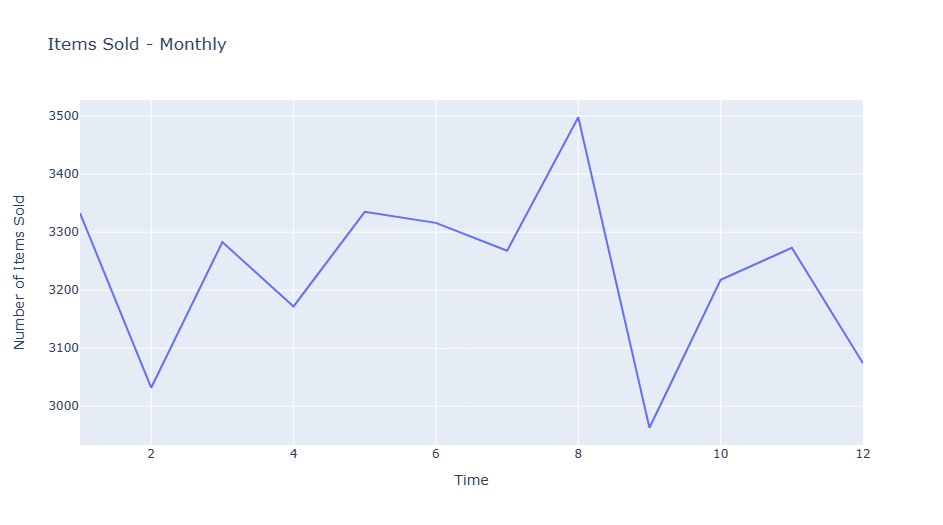

In [18]:
# Widget for selecting the year
year_widget = widgets.Dropdown(
    options=['2014', '2015', 'All'],
    value='All',
    description='Year:'
)

def plot_top_items(df, year):
    # Filter data based on the selected year
    if year == 'All':
        df_filtered = df
    else:
        df_filtered = df[df['year'] == int(year)]

    # Group by itemDescription and calculate the sum of sales
    top_items = df_filtered.groupby('itemDescription').size().reset_index(name='Count')
    
    # Sort in descending order
    top_items = top_items.sort_values(by='Count', ascending=False).head(10)

    # Reverse the order of bars
    top_items = top_items[::-1]

    # Plot using Plotly for interactive horizontal bar chart
    fig = px.bar(
        top_items,
        x='Count',
        y='itemDescription',
        orientation='h',
        title=f'Top 10 Items Sold - {year}' if year != 'All' else 'Top 10 Items Sold - All Period'
    )
    fig.update_xaxes(title_text='Number of Items Sold')
    fig.update_yaxes(title_text='Item Description')

    # Display interactive plot
    fig.show()

# Interactive plot with widgets
@interact(year=year_widget)
def interactive_top_items(year):
    plot_top_items(df, year)

interactive(children=(Dropdown(description='Year:', index=2, options=('2014', '2015', 'All'), value='All'), Ou…

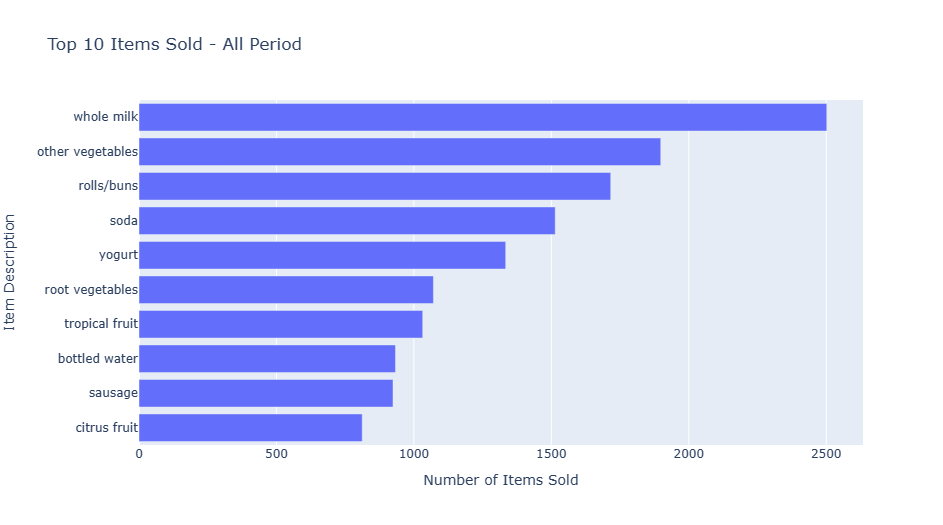

## Continuous Assessment 

### 1.1 Discuss and explain the purpose of a recommendation system for online retail business in machine learning. 

According to (Wikipedia Contributors, 2019), online retail, also well known as eCommerce, allows customers to buy goods or services using web-based technology. Electronic Commerce permit businesses all over the world, the opportunity to collect customers' data. Technology makes possible to build customers’ profiles based on demographic data, purchase history, preferences, and active data such as likes, views, clicks, and time spent. 

AI has helped businesses to build powerful analytics tools to improve customer satisfaction and drive revenue.  Recommendation Systems enable businesses to learn about their customers, and so provide more meaningful content, increasing customer satisfaction, and drive business revenue. 

Industry leaders in online retail are using recommendation systems. Amazon’s recommendations are responsible for 35% of revenue, Netflix’s recommendations are responsible for 75% of the movies seen on the platform, and 60% of the videos watched on YouTube were recommended to their customers.

Recommendation engines enable customers to find goods or services using different algorithms. They are: Contant-based filtering, based on item features and user profile data; Collaborative-based filtering, based on the similarity with other users (user-to-user or item-to-item); and Hybrid systems that combine Contant-based filtering, and Collaborative-based filtering.


### 1.2)	Briefly compare Content and Collaborative filtering using any dataset of your choice. Train and test machine learning models for the user-user or item-item collaborative filtering. 

### 1.3)	Justify your recommendations for the considered scenario by providing a conceptual insight. 

### 2.1) Perform Market Basket Analysis on the chosen dataset by using Apriori and FP growth algorithms.

### 2.2) Can you express the major divergence between these models? Compare and contrast the machine learning results obtained based on both algorithms. 

### 3.1) Create an interactive Dashboard aimed at older adults (65+) with specific features to summarise the most important aspects of the data and identify through your visualisation why this dataset is suitable for Machine Learning models in an online retail business. 

### 3.2) Explain how your dashboard is designed with this demographic in mind.